# Isochrone Match

We match observed NUVo measurements to theoretical NUVo predictions for isochrones of age ~30Myr. We use this matching schema to estimate the masses of individual stars, assess the region's mass function, and calculated an estimated total stellar mass for the SMC Wing.

## Import modules

In [1]:
# Standard
import numpy as np
import matplotlib.pyplot as plt

# Auxillary
import smc
from scipy import stats
import scipy.integrate as integrate

## Foreground-corrected photometry

In [2]:
# Original files
data = np.genfromtxt('../data/foreground_corrected_photometry')

id_number, ra, dec, nuv_v, nuv, b_v, v = data[:,0], data[:,1], data[:,2], \
data[:,3], data[:,4], data[:,5], data[:,6]

print("There are {} field stars in our sample".format(len(nuv)))

There are 1073 field stars in our sample


# Color-magnitude diagram with isochrones

In this study, isochrones from the University of Padova (Link: http://stev.oapd.inaf.it/cgi-bin/cmd ) were designed to represent stars of constant age and metallicity, and with varying masses. When overplotted with our NUV$_\circ$ vs. (NUV-V)$_\circ$ CMD, they effectively quantify the relative age patterns revealed within our sample, without ever being fit to our data directly.

In [3]:
# Isochrone model
models = np.genfromtxt('../data/Isochrone_Models', delimiter=' ')

# The class smc.organize_models automatically applies the Vega -> AB magnitude correction, so within
# this notebook, the corrections are applied. A little further down, when we interact with the data
# unprocessed, we need to continue continue to apply the Vega -> AB magnitude correction.
model72, model73, model74, model75, model76, model77, model78, model79, model80 = \
smc.organize_models(models, 1.58e+07), smc.organize_models(models, 2.00e+07), \
smc.organize_models(models, 2.51e+07), smc.organize_models(models, 3.16e+07), \
smc.organize_models(models, 3.98e+07), smc.organize_models(models, 5.01e+07), \
smc.organize_models(models, 6.31e+07), smc.organize_models(models, 7.94e+07), \
smc.organize_models(models, 1.00e+08)

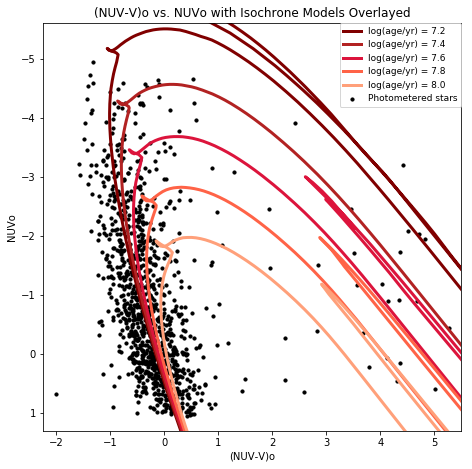

In [4]:
plt.figure(figsize=(7.5,7.5))

plt.scatter(nuv_v, nuv, color='black', label="Photometered stars", s=10, marker="o")
plt.plot(model72.nuv_v, model72.nuv, color='maroon', label='log(age/yr) = 7.2', linewidth=3)
plt.plot(model74.nuv_v, model74.nuv, color='firebrick', label='log(age/yr) = 7.4', linewidth=3)
plt.plot(model76.nuv_v, model76.nuv, color='crimson', label='log(age/yr) = 7.6', linewidth=3)
plt.plot(model78.nuv_v, model78.nuv, color='tomato', label='log(age/yr) = 7.8', linewidth=3)
plt.plot(model80.nuv_v, model80.nuv, color='lightsalmon', label='log(age/yr) = 8.0', linewidth=3)

smc.plt_nuv('(NUV-V)o vs. NUVo with Isochrone Models Overlayed', True)
plt.show()

In [5]:
# Generalizing model variables
model = model76
model.nuv = model76.nuv
model.v = model76.v
model.nuv_v = model76.nuv_v

In [6]:
# Setting up variables for the observed-model match
photometered_nuv = nuv
photometered_nuv_v = nuv_v

In [7]:
def find_nearest(array, value):
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx

In [8]:
# Define matching function
# NOTE: The magnitude in the output file is the VEGA magnitude, NOT the AB magnitude!!

def observed_model_match(output_file, photometered_sample, model_nuv_sample, model_data_sample):
    output_file = open(output_file, 'w')
    magnitude_isochrone = []
    for i in photometered_sample:
        nearest_model_nuv_value, idx = find_nearest(model_nuv_sample, i)
        
        model_entire_row = model_data_sample[idx]
        i_as_array = np.asarray([[i]])
        
        magnitude_isochrone.append([i_as_array, model_entire_row])
        output_file.write("%s %s\n" % (i_as_array, model_entire_row))
    output_file.close()

observed_model_match('../data/nuv_isochrone_match_model76', photometered_nuv, model.nuv, model.data)

In [9]:
# Cleaning output file
!tr -d '\n' < ../data/nuv_isochrone_match_model76 > ../data/nuv_isochrone_match_model76_2
!tr '[[' '\n' < ../data/nuv_isochrone_match_model76_2 > ../data/nuv_isochrone_match_model76_3
!tr ']]' ' ' < ../data/nuv_isochrone_match_model76_3 > ../data/nuv_isochrone_match_model76_4
!grep . ../data/nuv_isochrone_match_model76_4 > ../data/nuv_isochrone_match_model76_5
!sed 'N;s/\n/ /' ../data/nuv_isochrone_match_model76_5 > ../data/nuv_isochrone_match_model76_6
!awk 'NF==29{print}{}' ../data/nuv_isochrone_match_model76_6 > ../data/nuv_isochrone_match_model76_clean
!wc -l ../data/nuv_isochrone_match_model76_clean

    1073 ../data/nuv_isochrone_match_model76_clean


In [10]:
# Uploading the cleaned file
isochrone_match_76 = np.genfromtxt('../data/nuv_isochrone_match_model76_clean')

# Double-check
# Note: it's okay if the following values are not exactly the same. The "nearest" function above matches each
# observed NUVo value to the *nearest* theoretical NUVo value. It is unlikely that any match will give the 
# exact same values.
# print(isochrone_match_76[:,25][0:5] + 1.7)
# print(photometered_nuv[0:5])

In [11]:
# Define variables based on match
# Remeber to convert Vega --> AB on the model magnitudes
photometered_nuv, model_nuv, model_v = \
isochrone_match_76[:,0], isochrone_match_76[:,25] + 1.7, isochrone_match_76[:,28]

model_nuv_v = model_nuv - model_v

age = isochrone_match_76[:,2]
mass = isochrone_match_76[:,4]
logL = isochrone_match_76[:,5]

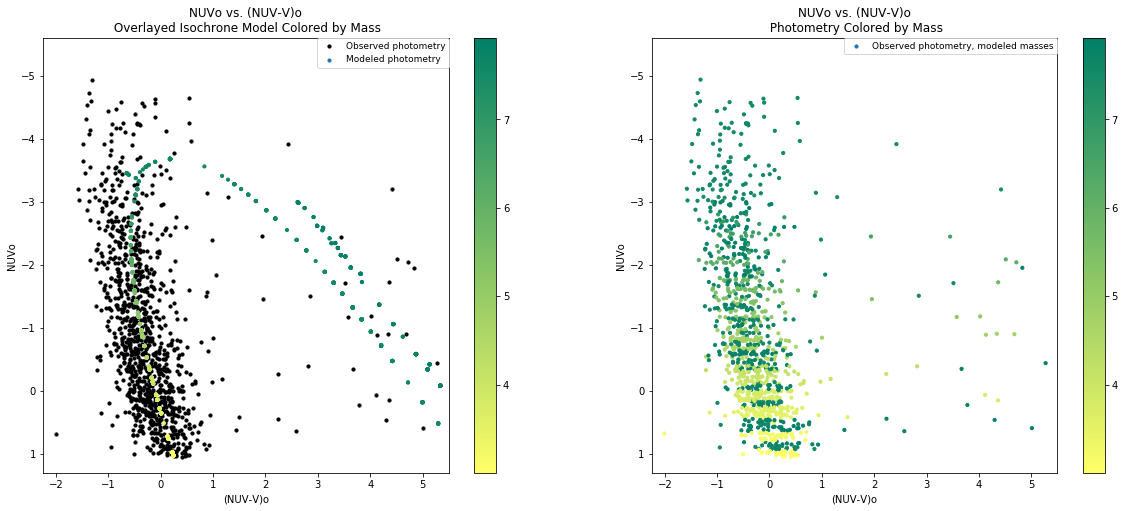

In [12]:
# Plot observed CMD with markers colored according to their associated theoretical mass.

plt.figure(figsize=(20,8))
plt.subplot(121)
plt.scatter(nuv_v, nuv, color='black', label="Observed photometry", s=10, marker="o")
plt.scatter(model_nuv_v, model_nuv, c=mass, label="Modeled photometry", s=10, marker="o", cmap="summer_r")
smc.plt_nuv('NUVo vs. (NUV-V)o\n Overlayed Isochrone Model Colored by Mass', True)
plt.colorbar()

plt.subplot(122)
plt.scatter(nuv_v, nuv, c=mass, label="Observed photometry, modeled masses", s=10, marker="o", cmap="summer_r")
smc.plt_nuv('NUVo vs. (NUV-V)o\n Photometry Colored by Mass', True)
plt.colorbar()

plt.show()

## Analysis

What we see in the above plots is that the "nearest" function has worked perfectly! It has matched observed NUVo values with their closest theoretical NUVo values, whether or not they make any physical sense. And, since our isochrone contains evolved, high-mass stars, the results of the above match indeed do not make physical sense (see the 'bands' of high-mass stars throughout the main sequence). To alleviate this issue, we are going to remove the evolved, high-mass stars from both the isochrone model sample and the observed sample. We have assessed that these stars are too few in number and live too briefly to significantly alter the results of this study.

Below we repeat the workflow with the applied color / magnitude limits as described above.

## Workflow with an applied color / magnitude threshold to both observed and model data

In [13]:
# Applying color threshold to observed data
main = np.where(nuv_v < 1.23)
id_number_main = id_number[main]
ra_main = ra[main]
dec_main = dec[main]
nuv_v_main = nuv_v[main]
nuv_main = nuv[main]
v_main = v[main]

print('When we remove stars that have evolved off the main sequence \
plume , we are left with {} stars in our sample'.format(len(id_number_main)))

When we remove stars that have evolved off the main sequence plume , we are left with 1042 stars in our sample


In [14]:
# Apply color and nuv thresholds to model
# The model requires both color and nuv corrections because it covers a far wider 
# range of NUV values than our photometric data
model_limits = np.where(np.logical_and(model.nuv_v < 1.23, model.nuv < 1.15))
model_main = model.data[model_limits]
model_nuv_main = model.nuv[model_limits]
model_v_main = model.v[model_limits]
model_nuv_v_main = model.nuv_v[model_limits]

print('When we isolate the modeled photometry to covered the same color-magnitude range as our\
observed photometry, our modeled sample contains {} evolutionary steps'.format(len(model_nuv_main)))

When we isolate the modeled photometry to covered the same color-magnitude range as ourobserved photometry, our modeled sample contains 77 evolutionary steps


In [15]:
# Setting up variables for the observed-model match with color threshold
photometered_nuv_main = nuv_main

In [16]:
# Define matching function with color threshold
observed_model_match('../data/main_nuv_isochrone_match_model76', photometered_nuv_main, model_nuv_main, model_main)

In [17]:
# Cleaning output file
!tr -d '\n' < ../data/main_nuv_isochrone_match_model76 > ../data/main_nuv_isochrone_match_model76_2
!tr '[[' '\n' < ../data/main_nuv_isochrone_match_model76_2 > ../data/main_nuv_isochrone_match_model76_3
!tr ']]' ' ' < ../data/main_nuv_isochrone_match_model76_3 > ../data/main_nuv_isochrone_match_model76_4
!grep . ../data/main_nuv_isochrone_match_model76_4 > ../data/main_nuv_isochrone_match_model76_5
!sed 'N;s/\n/ /' ../data/main_nuv_isochrone_match_model76_5 > ../data/main_nuv_isochrone_match_model76_6
!awk 'NF==29{print}{}' ../data/main_nuv_isochrone_match_model76_6 > ../data/main_nuv_isochrone_match_model76_clean
!wc -l ../data/main_nuv_isochrone_match_model76_clean

    1042 ../data/main_nuv_isochrone_match_model76_clean


In [19]:
# Uploading the cleaned file
main_isochrone_match_76 = np.genfromtxt('../data/main_nuv_isochrone_match_model76_clean')

# Double-check
# print(main_isochrone_match_76[:,25][0:5] + 1.7)
# print(photometered_nuv_main[0:5])

In [20]:
# Define variables based on match (for color threshold)
# Remeber to convert Vega --> AB on the model magnitudes
photometered_nuv_main, model_nuv_main, model_v_main = \
main_isochrone_match_76[:,0], main_isochrone_match_76[:,25] + 1.7, main_isochrone_match_76[:,28]

model_nuv_v_main = model_nuv_main - model_v_main

age_main = main_isochrone_match_76[:,2]
mass_main = main_isochrone_match_76[:,4]
logL_main = main_isochrone_match_76[:,5]

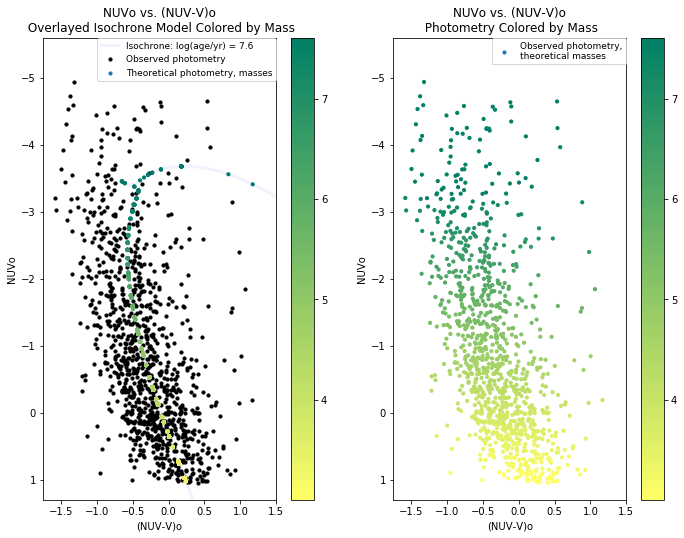

In [21]:
# Plot observed CMD with markers colored according to their associated theoretical mass.

plt.figure(figsize=(11.5,8.5))
plt.subplot(121)
plt.scatter(nuv_v_main, nuv_main, color='black', label="Observed photometry", s=10, marker="o")
plt.scatter(model_nuv_v_main, model_nuv_main, c=mass_main, label="Theoretical photometry, masses", s=10, marker="o", cmap="summer_r")
plt.plot(model.nuv_v[model.nuv>=-4.7], model.nuv[model.nuv>=-4.7], color='blue', label='Isochrone: log(age/yr) = 7.6', linewidth=3, alpha=0.05)

smc.plt_nuv('NUVo vs. (NUV-V)o\n Overlayed Isochrone Model Colored by Mass', True)
plt.xlim(-1.75, 1.5)
plt.colorbar()

plt.subplot(122)
plt.scatter(nuv_v_main, nuv_main, c=mass_main, label="Observed photometry,\ntheoretical masses", s=10, marker="o", cmap="summer_r")
smc.plt_nuv('NUVo vs. (NUV-V)o\n Photometry Colored by Mass', True)
plt.xlim(-1.75, 1.5)
plt.colorbar()

plt.show()

## Analysis

The relationship we've established between mass and luminosity is sufficient for us to continue.

In [22]:
# Sum masses for all observed stars
print('There are {} stars in the above stellar sample. The "observed" stellar mass \
for our sample (summing the theoretical masses for all photometered stars) is {} \
solar masses. This gives us an average stellar mass of {} for our sample. The \
total theoretical luminosity for this sample is {} solar luminosities. This gives \
us an average stellar luminosity of {} solar luminosities for our stellar sample.\
'.format(len(mass_main), np.round(sum(mass_main), 2), \
         np.round(sum(mass_main)/len(mass_main), 2), \
         np.round(sum(10 ** logL_main), 2), \
         np.round(sum(10 ** logL_main)/sum(mass_main), 2)))

# Does this make sense??

There are 1042 stars in the above stellar sample. The "observed" stellar mass for our sample (summing the theoretical masses for all photometered stars) is 5090.51 solar masses. This gives us an average stellar mass of 4.89 for our sample. The total theoretical luminosity for this sample is 1596294.07 solar luminosities. This gives us an average stellar luminosity of 313.58 solar luminosities for our stellar sample.


In [32]:
# Examine the mass function of these stars
# This present-day mass funciton is meant to reveal any unusual 
# behavior in the mass function, and not meant to be treated as ground truth 

frequency_density = []
average_mass_for_each_bin = []

n = 90
range = np.arange(int(len(id_number_main) / n))

for i in range:
    start = i * n
    end = start + n
    bin_i = np.sort(mass_main)[start:end]
    average_mass_for_bin_i = np.mean(bin_i)
    average_mass_for_each_bin.append(average_mass_for_bin_i)
    
    mass_range_i = max(bin_i) - min(bin_i)
    freq_density = n / mass_range_i
    frequency_density.append(freq_density)

log_frequency_density = np.log10(frequency_density)
log_average_mass = np.log10(average_mass_for_each_bin)

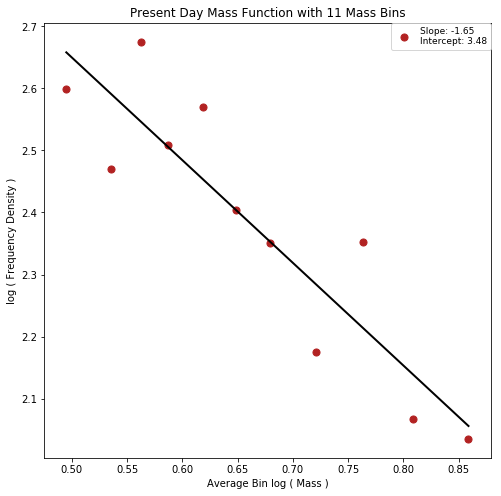

In [33]:
# Plot the mass function

plt.figure(figsize=(8,8))
x = log_average_mass
y = log_frequency_density

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
plt.scatter(x, y, s=50, \
            color='firebrick', label='Slope: '+str(np.round(slope, 2))+'\nIntercept: '+\
            str(np.round(intercept, 2)))

plt.plot(x, x * slope + intercept, linewidth=2, color='black')
smc.plt_parameters('Present Day Mass Function with '+str(range[-1] + 1)+' Mass Bins', \
                   'Average Bin log ( Mass )', \
               'log ( Frequency Density )', min(y) - 0.03 , max(y) + 0.03, \
                   min(x) - 0.02, max(x) + 0.02, True)

plt.savefig("images/Present_Day_Mass_Function.jpg")
plt.show()

In [36]:
# Convert observed stellar mass to theoretical / total stellar mass

slope = -2.35

min_observed_mass = min(mass_main)
max_observed_mass = max(mass_main)
min_theoretical_mass = 0.5
max_theoretical_mass = max(mass_main) + 1

theoretical = integrate.quad(lambda m: m**(slope + 1), min_theoretical_mass, max_theoretical_mass)[0] + \
integrate.quad(lambda m: m**(slope + 2), 0.08, 0.5)[0]
observed = integrate.quad(lambda m: m**(slope + 1), min_observed_mass, max_observed_mass)[0]
ratio = theoretical / observed

In [38]:
print('For the following parameters:\n')

# FIX THIS BELOW!! UNDERSTAND THE INTEGRAL
print('Observed slope for the present-day mass function', np.round(slope, 2))
print('Observed stellar mass range in solar masses: [{}, {}]'.format(min_observed_mass, max_observed_mass))
print('Theoretical stellar mass range in solar masses: [{}, {}]'\
      .format(min_theoretical_mass, max_theoretical_mass))

print('\nThe "observed" stellar mass is {} solar masses. The theoretcal-to-observed stellar mass ratio is {}. \
Therefore, the theoretical stellar mass for this region is {} solar masses.'\
      .format(np.round(sum(mass_main), 2), np.round(ratio, 2), \
              np.round(sum(mass_main) * ratio, 2)))

For the following parameters:

Observed slope for the present-day mass function -2.35
Observed stellar mass range in solar masses: [3.001, 7.608]
Theoretical stellar mass range in solar masses: [0.5, 8.608]

The "observed" stellar mass is 5090.51 solar masses. The theoretcal-to-observed stellar mass ratio is 5.43. Therefore, the theoretical stellar mass for this region is 27621.3 solar masses.
